In [31]:
# common
import pandas as pd
import numpy as np
import datetime
import random

# ML
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# visulization
import matplotlib.pyplot as plt 
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings("ignore")

In [32]:
df = pd.read_csv("E:\skill based learning\DATA SCIENCE\Learn_Projects\Rosemann Store Retail Sales Pred\ml_ready2.csv", low_memory = False)

In [33]:
df.head()

,store,date,date.1,month,year,dayofweek,sales,customers,promo,state_hd,school_hd,store_type,assortment,comp_dist,comp_syr,promo2,promo_active,comp_time_months_real,promo2_time_months_real
0,494,2013-01-01,1,1,2013,2,8.043663,6.269096,0,1,1,3,1,-0.173420,2011,0,0,-0.454545,0
1,274,2013-01-01,1,1,2013,2,8.040125,6.593045,0,1,1,3,3,0.212318,1994,1,1,1.585859,0
2,530,2013-01-01,1,1,2013,2,7.975221,6.278521,0,1,1,1,2,2.565640,2014,0,0,-0.646465,0
3,676,2013-01-01,1,1,2013,2,8.248529,6.656727,0,1,1,3,3,-0.149109,2008,0,0,-0.121212,0
4,733,2013-01-01,1,1,2013,2,9.284148,7.774015,0,1,1,3,3,-0.238250,1999,0,0,0.979798,0


In [34]:
df['date'] = pd.to_datetime(df.date, format  = '%Y-%m-%d')

In [35]:
# define out boundary date
edge_date = pd.to_datetime(max(df.date) - datetime.timedelta(days = 6*7))

# split X train and test parts
X_train = df[df.date < edge_date]
y_train = X_train.sales
X_train.drop('sales', axis = 1, inplace = True)

X_test = df[df.date >= edge_date]
y_test = X_test.sales
X_test.drop('sales', axis = 1, inplace = True)

# date diff
print("Minimun Train date : {}\nMaximum test date : {}".format(X_train.date.min(), X_train.date.max()))
print("Maximum Test date : {}".format(X_test.date.max()))

# save the dates before dropping
X_train_id = X_train.date
X_test_id = X_test.date

# drop date (Not useful in regression)
X_train.drop('date', axis = 1, inplace = True)
X_test.drop('date', axis = 1, inplace = True)

Minimun Train date : 2013-01-01 00:00:00
Maximum test date : 2015-06-18 00:00:00
Maximum Test date : 2015-07-31 00:00:00


In [36]:
print("Train size : {}\nTest size : {}".format(X_train.shape[0], X_test.shape[0]))

Train size : 802996
Test size : 41396


In [37]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y)*100)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({"MAE": mae,
                         "MAPE": mape,
                         "RMSE": rmse}, index=[model_name])

In [38]:
##  model
lr = LinearRegression()
lr.fit(X_train, y_train)

# prediction
y_pred_lr = lr.predict(X_test)

# perfomance
# np.expm1 is anti logarithm
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(y_pred_lr))
lr_result

,MAE,MAPE,RMSE
Linear Regression,1045.567936,15.048535,1458.299329


In [39]:
# model
lrr = Lasso(alpha=0.01)
lrr.fit(X_train, y_train)

# prediction
y_pred_lrr = lrr.predict(X_test)

# perfomance
lrr_result = ml_error("LR Lasso", np.expm1(y_test), np.expm1(y_pred_lrr))
lrr_result

,MAE,MAPE,RMSE
LR Lasso,1107.31162,15.65984,1582.536818


In [40]:
# model
rf = RandomForestRegressor(
                            n_estimators=30,
                            random_state=42
                          )
rf.fit(X_train, y_train)

# prediction
y_pred_rf = rf.predict(X_test)

# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(y_pred_rf))
rf_result

,MAE,MAPE,RMSE
Random Forest Regressor,383.056572,5.460499,577.587849


In [41]:
# model
xgbr = XGBRegressor(
                    n_estimators = 70,
                    eta = 0.1,
                    max_depth = 10,
                    subsample = 0.7,
                    )

xgbr.fit(X_train, y_train)

# prediction
y_pred_xgb = xgbr.predict(X_test)

# performance
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(y_pred_xgb))
xgb_result

,MAE,MAPE,RMSE
XGBoost Regressor,509.387744,7.273343,739.627401


In [56]:
# INCLUDDE SARIMA DATA 365.871221	12.661554	434.03083
sarima_err = pd.DataFrame({'MAE' : 365.871221, 'MAPE' : 12.661554, "RMSE" : 434.03083}, index = ['SARIMA'])
models = pd.concat([sarima_err, lr_result, lrr_result, rf_result, xgb_result])
models.sort_values(by = 'RMSE')

,MAE,MAPE,RMSE
SARIMA,365.871221,12.661554,434.030830
Random Forest Regressor,383.056572,5.460499,577.587849
XGBoost Regressor,509.387744,7.273343,739.627401
Linear Regression,1045.567936,15.048535,1458.299329
LR Lasso,1107.311620,15.659840,1582.536818


#### **I Will use best in above table and it is ```RandomForestRegressor``` model for hyperparameter tuning and select the best parameters for our prediction from them**

### **Hyperparameter Tuning**

In [13]:
"""import dask.dataframe as dd
# from dask_ml.wrappers import RandomForestRegressor as dask_rfr
# from dask_ml import joblib
from sklearn.externals.joblib import parallel_backend"""

'import dask.dataframe as dd\n# from dask_ml.wrappers import RandomForestRegressor as dask_rfr\n# from dask_ml import joblib\nfrom sklearn.externals.joblib import parallel_backend'

In [14]:
"""dask_train_X = dd.from_pandas(X_train, npartitions=10)
dask_test_X = dd.from_pandas(X_test, npartitions=10)
dask_train_y = dd.from_pandas(y_train, npartitions=10) 
dask_test_y = dd.from_pandas(y_test, npartitions=10) """

'dask_train_X = dd.from_pandas(X_train, npartitions=10)\ndask_test_X = dd.from_pandas(X_test, npartitions=10)\ndask_train_y = dd.from_pandas(y_train, npartitions=10) \ndask_test_y = dd.from_pandas(y_test, npartitions=10) '

In [10]:
rfr_params = {
    'n_estimators' : [20, 30],          # Number of trees in the forest
    'criterion' : ['squared_error', 'absolute_error'],       # Criteria used to measure the quality of a split ('mse' for mean squared error)
    'max_depth' : [7, 10],           # Maximum depth of the tree (default=None, nodes are expanded until they contain less than min_samples_split samples)
    'oob_score' : [True, False],         # Whether to use out-of-bag samples to estimate the R^2 on unseen data
    }

In [8]:
"""final_result = pd.DataFrame()
max_iterations = 0
preds = []
used_hps = []
max_loops = 0
while max_loops < 10:

    # loop increment
    max_loops +=1
    # choose values for parameters randomly
    hp = {k : random.sample(v, 1)[0] for k, v in rfr_params.items() }
    print(hp)
    
    # check whether the hp has been used before if it is then skip the loop.
    if hp in used_hps: 
        continue
    # model
    rfr = RandomForestRegressor  ( 
                                  #random_state = 42   
                                  n_estimators = hp['n_estimators'],  
                                  max_depth = hp['max_depth'],
                                  criterion = hp['criterion'], 
                                  oob_score = hp['oob_score']
                                  )
    # fit the data
    rfr.fit(X_train, y_train)
    # predict
    y_pred = rfr.predict(X_test)
    # save the predictions as pandas dataframe
    preds.append(y_pred)
    used_hps.append(hp)
    # get the perfomance and save it to dataframe
    #final_result = pd.concat( [final_result, ml_error(f"{rfr.get_params()}", np.expm1(y_test), np.expm1(y_pred))] )
    max_iterations+=1
    if max_iterations >= 3:
        break
final_result
"""

'final_result = pd.DataFrame()\nmax_iterations = 0\npreds = []\nused_hps = []\nmax_loops = 0\nwhile max_loops < 10:\n\n    # loop increment\n    max_loops +=1\n    # choose values for parameters randomly\n    hp = {k : random.sample(v, 1)[0] for k, v in rfr_params.items() }\n    print(hp)\n    \n    # check whether the hp has been used before if it is then skip the loop.\n    if hp in used_hps: \n        continue\n    # model\n    rfr = RandomForestRegressor  ( \n                                  #random_state = 42   \n                                  n_estimators = hp[\'n_estimators\'],  \n                                  max_depth = hp[\'max_depth\'],\n                                  criterion = hp[\'criterion\'], \n                                  oob_score = hp[\'oob_score\']\n                                  )\n    # fit the data\n    rfr.fit(X_train, y_train)\n    # predict\n    y_pred = rfr.predict(X_test)\n    # save the predictions as pandas dataframe\n    preds.append(y

In [13]:
rfr1 = RandomForestRegressor  ( 
                                  #random_state = 42   
                                  n_estimators = 30,  
                                  max_depth = 7,
                                  criterion = 'squared_error', 
                                  oob_score = True
                                  )
rfr1.fit(X_train, y_train)
y_pred_1 = rfr1.predict(X_test)

NameError: name 'y_pred_xgb' is not defined

In [14]:
rfr1_result = ml_error("30 Trees 7 depth SE True OOB", np.expm1(y_test), np.expm1(y_pred_1))
rfr1_result

,MAE,MAPE,RMSE
30 Trees 7 depth SE True OOB,974.238857,13.633249,1388.853045


In [15]:
rfr1 = RandomForestRegressor  ( 
                                  #random_state = 42   
                                  n_estimators = 30,  
                                  max_depth = 10,
                                  criterion = 'squared_error', 
                                  oob_score = True
                                  )
rfr1.fit(X_train, y_train)
y_pred_2 = rfr1.predict(X_test)

,MAE,MAPE,RMSE
30 Trees 7 depth SE True OOB,856.070738,11.993107,1222.522799


In [8]:
rfr3 = RandomForestRegressor  ( 
                                  #random_state = 42   
                                  n_estimators = 30,  
                                  max_depth = 10
                                  )
rfr3.fit(X_train, y_train)
y_pred_3 = rfr3.predict(X_test)
rfr3_result = ml_error("30 Trees 10 depth AE True OOB", np.expm1(y_test), np.expm1(y_pred_3))
rfr3_result

,MAE,MAPE,RMSE
30 Trees 10 depth AE True OOB,855.377193,11.999262,1220.91006


In [9]:
rfr4 = RandomForestRegressor(
                            #random_state = 42   
                            n_estimators = 40,  
                            max_depth = 7
                                  )
rfr4.fit(X_train, y_train)
y_pred_4 = rfr4.predict(X_test)


,MAE,MAPE,RMSE
30 Trees 10 depth AE True OOB,973.077563,13.628461,1387.637334


In [11]:
rfr4_result = ml_error("40 Trees 7 depth", np.expm1(y_test), np.expm1(y_pred_4))
rfr4_result

,MAE,MAPE,RMSE
40 Trees 7 depth,973.077563,13.628461,1387.637334


In [12]:
rfr5 = RandomForestRegressor(
                            #random_state = 42   
                            n_estimators = 40,  
                            max_depth = 10
                                  )
rfr5.fit(X_train, y_train)
y_pred_5 = rfr5.predict(X_test)
rfr5_result = ml_error("40 Trees 10 depth AE True OOB", np.expm1(y_test), np.expm1(y_pred_5))
rfr5_result

,MAE,MAPE,RMSE
40 Trees 10 depth AE True OOB,855.666039,11.998988,1221.827732



 ### `Random Forest Regressor` is giving best results when n_estimators = 30, random_state = 42.
 #### All other parameters are default.
 #### **Here is the default Values that are being used.**
 > **n_estimators = 30 <br>
 random_state = 42<br>
 criterion = 'gini'<br>
 max_depth = None<br>
 min_samples_split = 2<br>
 min_samples_leaf = 1<br>
 max_features = 'auto'<br>
 bootstrap = True<br>
 oob_score = False<br>
 class_weight = None**


In [43]:
# So the final model shall look like below
 rfr = RandomForestRegressor(
                               n_estimators = 30 <br>
                                random_state = 42
                                criterion = 'gini'
                                max_depth = None
                                min_samples_split = 2
                                min_samples_leaf = 1
                                max_features = 'auto'
                                bootstrap = True
                                oob_score = False
                                class_weight = None
                            )
rfr.fit(X_train, y_train)
y_pred_rf_ = rfr.predict(X_test)
# 
# )

,MAE,MAPE,RMSE
Random Forest Regressor,383.056572,5.460499,577.587849


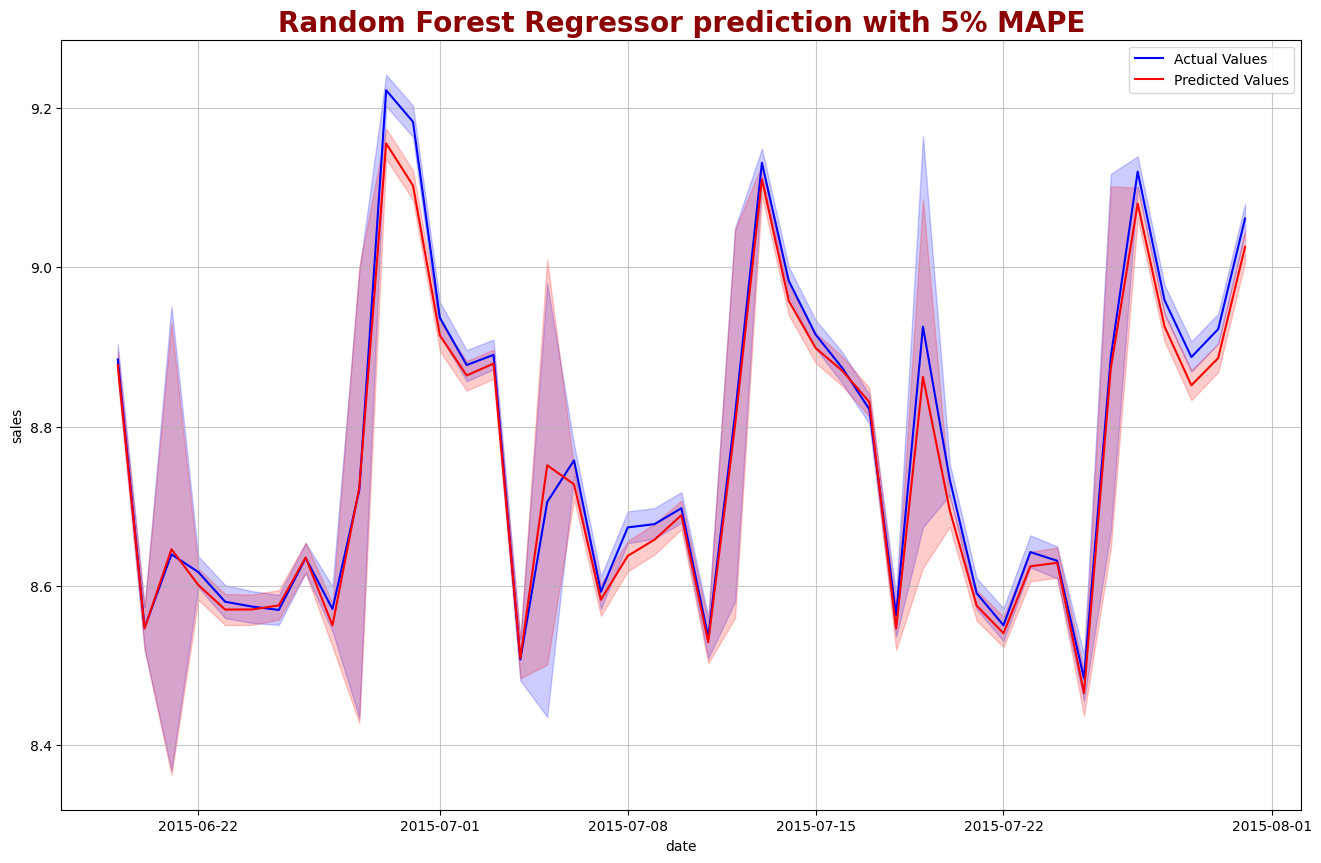

In [44]:
results = pd.concat([pd.Series(X_test_id).reset_index(), pd.Series(y_test).reset_index(), pd.Series(y_pred_rf).reset_index()], axis = 1)
# lets plot the prediction and check the outcome.
results.rename(columns = {0 : 'preds'}, inplace = True)
plt.figure(figsize = (16, 10))
sns.lineplot(results, x = 'date', y = 'sales', color = 'blue', label = 'Actual Values')
sns.lineplot(results, x = 'date',y = 'preds', color = 'red', label = 'Predicted Values')
plt.title("Random Forest Regressor prediction with 5% MAPE", fontdict = {'size' : 20, 'family' : 'sans', 'color' : 'darkred',
                                                                            'weight' : 'bold'})
plt.grid(alpha = 0.7)                                                                           
plt.show()

### This is great !. Our model have predicted with least error space.
### Now I will Sum up the predictions to get the total forecast revenue in next 6 weeks

In [45]:
"💲{:,.2f}".format(np.expm1(results.preds).sum())

'💲282,578,436.77'

## **So the the predicted forecast is 282,578,436.77 💲**. 
### I will findout the predictions on worst case and best case scenario using MAE and MSE. 

In [46]:
# lets just inverse transform our predections to real price
results['sales'] = np.expm1(results.sales)
results['preds'] = np.expm1(results.preds)

In [47]:
# check errors again
mae = mean_absolute_error(results.sales, results.preds)
mape = mean_absolute_percentage_error(results.sales, results.preds)
mse = mean_squared_error(results.sales, results.preds)
mae, mse, mape

(383.0565716665342, 333607.72332139424, 5.460499057258649)

In [51]:
X_test.reset_index(inplace=True)
X_test['preds'] = results.preds
X_test['sales'] = results.sales

,index,store,date.1,month,year,dayofweek,customers,promo,state_hd,school_hd,...,promo2,promo_active,comp_time_months_real,promo2_time_months_real,preds,sales,worst_case_mae,best_case_mae,worst_case_mse,best_case_mse
0,802996,540,19,6,2015,5,6.230481,1,4,0,...,1,0,0.070707,31,7679.554224,7721.0,2.825780e+08,2.825788e+08,2.821936e+08,2.829633e+08
1,802997,211,19,6,2015,5,7.337588,1,4,0,...,0,0,0.414141,0,13429.112004,14771.0,2.825780e+08,2.825788e+08,2.821936e+08,2.829633e+08
2,802998,676,19,6,2015,5,7.612831,1,4,0,...,0,0,0.181818,0,9307.036466,9568.0,2.825780e+08,2.825788e+08,2.821936e+08,2.829633e+08
3,802999,1047,19,6,2015,5,6.461468,1,4,0,...,1,0,-0.252525,68,6064.920419,5634.0,2.825780e+08,2.825788e+08,2.821936e+08,2.829633e+08
4,803000,88,19,6,2015,5,6.606650,1,4,0,...,0,0,0.545455,0,7375.372608,7183.0,2.825780e+08,2.825788e+08,2.821936e+08,2.829633e+08


In [52]:
final = pd.DataFrame({  'Actual Prediction' : [282578436.77, 282578436.77], 
                        'Worst Case' : [282578436.77 - mae, 282578436.77 - mse], 
                        'Best Case' : [282578436.77 + mae, 282578436.77 + mse],
                        }, index = ['MAE', 'MSE'])
final['Worst Case'] = final['Worst Case'].apply(lambda x : "💲{:,.2f}".format(x))
final['Best Case'] = final['Best Case'].apply(lambda x : "💲{:,.2f}".format(x))
final['Actual Prediction'] = final['Actual Prediction'].apply(lambda x : "💲{:,.2f}".format(x))

final

,Actual Prediction,Worst Case,Best Case
MAE,"💲282,578,436.77","💲282,578,053.71","💲282,578,819.83"
MSE,"💲282,578,436.77","💲282,244,829.05","💲282,912,044.49"


### **Individual store sales forecast.**

In [55]:
u = X_test.groupby('store').preds.sum().head().reset_index(name = 'Prediction Forecast')
u['Prediction Forecast'] = u['Prediction Forecast'].apply(lambda x : "💲{:,.2f}".format(x))
u

,store,Prediction Forecast
0,1,"💲159,590.72"
1,2,"💲183,918.89"
2,3,"💲258,583.94"
3,4,"💲349,204.87"
4,5,"💲163,563.09"
